In [3]:
!pip uninstall mediapipe -y
!pip install mediapipe==0.10.18

  Using cached mediapipe-0.10.18-cp312-cp312-macosx_11_0_universal2.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.18-cp312-cp312-macosx_11_0_universal2.whl (49.1 MB)


In [87]:
import tensorflow as tf
import numpy as np
import cv2
import mediapipe as mp
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(mp.__version__)



2.19.0
1.26.4
4.12.0
0.10.18


## 1. Define MediaPipe functions and its utilities

In [7]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [13]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [11]:
def draw_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
def draw_styled_landmarks(image, results):
    # Draw face landmarks
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, results.face_landmarks, 
            mp_face_mesh.FACEMESH_TESSELATION,
            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )

    # Draw pose landmarks
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, 
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        )

    # Draw left hand landmarks
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.left_hand_landmarks, 
            mp_hands.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )

    # Draw right hand landmarks
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.right_hand_landmarks, 
            mp_hands.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )


In [15]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## 2. Real Time MediaPipe

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    # cv2.waitKey(100)  # Let the GUI process any remaining events
    cv2.destroyAllWindows()


In [64]:
import numpy as np
import cv2
from PIL import Image
import glob
import os

folder_path = '/Users/badershalata/Documents/MP_Data/hello/25/'

# Automatically get sorted list of all .npy files in the folder
landmark_files = sorted(glob.glob(os.path.join(folder_path, '*.npy')),
                        key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

img_h, img_w = 480, 640
frames = []

def draw_points_bold(image, points, color, radius=6):
    for lm in points:
        x_pix = int(lm[0] * img_w)
        y_pix = int(lm[1] * img_h)
        # Draw black border circle (thicker radius)
        cv2.circle(image, (x_pix, y_pix), radius + 2, (0, 0, 0), -1)
        # Draw colored circle on top
        cv2.circle(image, (x_pix, y_pix), radius, color, -1)

for file in landmark_files:
    landmarks = np.load(file)
    
    pose = landmarks[:33*4].reshape(33,4)
    face = landmarks[33*4:33*4 + 468*3].reshape(468,3)
    lh = landmarks[33*4 + 468*3 : 33*4 + 468*3 + 21*3].reshape(21,3)
    rh = landmarks[33*4 + 468*3 + 21*3 :].reshape(21,3)
    
    image = np.zeros((img_h, img_w, 3), dtype=np.uint8)
    
    draw_points_bold(image, pose[:, :2], (255, 0, 255))    # Purple
    draw_points_bold(image, face[:, :2], (0, 165, 255))    # Orange
    draw_points_bold(image, lh[:, :2], (255, 255, 255))    # White
    draw_points_bold(image, rh[:, :2], (255, 255, 0))      # Cyan
        # Red with border
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb_image)
    frames.append(pil_img)

# Save frames as GIF
frames[0].save('landmarks_animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=100, loop=0)


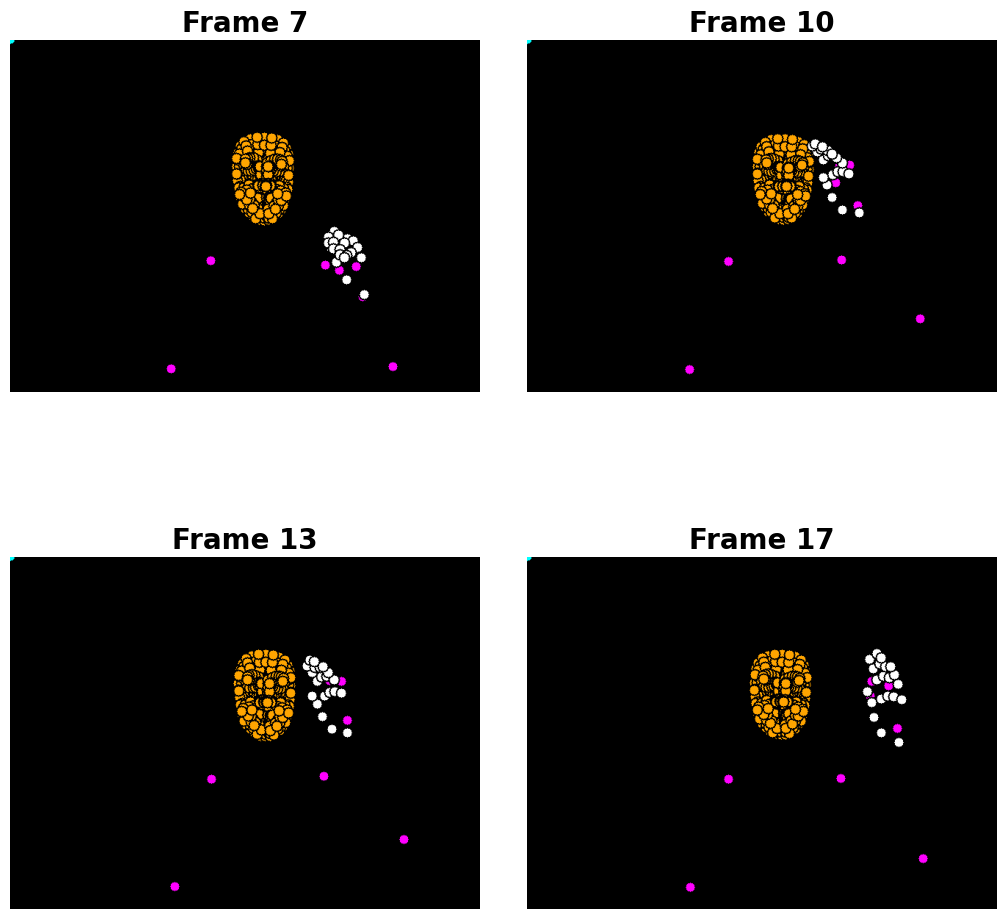

In [66]:
import matplotlib.pyplot as plt

selected_indices = [7, 10, 13, 17
                   ]

plt.figure(figsize=(10, 10))

for i, idx in enumerate(selected_indices):
    plt.subplot(2, 2, i + 1)
    plt.imshow(frames[idx])
    plt.title(f'Frame {idx}', fontsize=20, fontweight='bold')
    plt.axis('off')

plt.tight_layout(pad=0.5)      # reduce padding around subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # reduce space between subplots

plt.show()


## 3. Setup Folders

In [17]:
import os
import numpy as np

# Get your user's Documents directory
from pathlib import Path
DOCUMENTS_PATH = Path.home() / "Documents"

# Set full path to MP_Data inside Documents
DATA_PATH = os.path.join(DOCUMENTS_PATH, 'MP_Data')

# Define actions and setup
actions = np.array(['hello', 'thanks', 'iloveyou', 'go', 'why','when', 'eat', 'today', 'help',
                    'friend', 'goodbye','understand',"don't-understand",
                    
                    "i'm-good", 'how-are-you', 'my-name-is', 'good-morning', 
                    'see-you-later'])
# DO: WHEN, GOODBYE, HELP, FRIEND
# actions = np.array(["understand1"])
no_sequences = 30
sequence_length = 30

# # # Create folders for each action and sequence
# for action in actions: 
#     action_path = os.path.join(DATA_PATH, action)

# #     # Ensure action folder exists first (if it's the first time)
#     os.makedirs(action_path, exist_ok=True)

# #     # Get highest existing sequence number to avoid overwriting
#     existing = [int(name) for name in os.listdir(action_path) if name.isdigit()]
#     dirmax = max(existing) if existing else 0

#     for sequence in range(1, no_sequences + 1):
#         try: 
#             os.makedirs(os.path.join(action_path, str(dirmax + sequence)))
#         except FileExistsError:
#             pass


## 4. Collect Data

In [ ]:
start_folder = dirmax + 1
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in [actions[0]]:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                ### HERE FOR GOSON
                # npy_path = os.path.join(DATA_PATH, action, f'gosonand_{action}', str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

## 5. Preprocess and Label Creation

In [89]:
import sklearn
print(sklearn.__version__)


1.4.2


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [68]:
# encoding the labels
label_map = {label:num for num, label in enumerate(actions)}

In [23]:
label_map

{'hello': 0,
 'thanks': 1,
 'iloveyou': 2,
 'go': 3,
 'why': 4,
 'when': 5,
 'eat': 6,
 'today': 7,
 'help': 8,
 'friend': 9,
 'goodbye': 10,
 'understand': 11,
 "don't-understand": 12,
 "i'm-good": 13,
 'how-are-you': 14,
 'my-name-is': 15,
 'good-morning': 16,
 'see-you-later': 17}

In [25]:
import os
import numpy as np

sequences, labels = [], []
for action in actions[:18]:
    action_path = os.path.join(DATA_PATH, action)
    
    # Load sequences directly inside the action folder (if any)
    main_sequence_folders = [f for f in os.listdir(action_path) if f.isdigit()]
    for seq_folder in main_sequence_folders:
        seq_path = os.path.join(action_path, seq_folder)
        # Check if the folder contains the expected .npy files for the sequence length
        if all(os.path.exists(os.path.join(seq_path, f"{frame_num}.npy")) for frame_num in range(sequence_length)):
            window = []
            for frame_num in range(sequence_length):
                frame_path = os.path.join(seq_path, f"{frame_num}.npy")
                res = np.load(frame_path)
                window.append(res)
            sequences.append(window)
            # assigning label for the sequence here
            labels.append(label_map[action])
        else:
            # Skip if frames missing
            continue

    # # Check for a subfolder named gosonand_<action>
    # signer_folder = os.path.join(action_path, f"gosonand_{action}")
    # if os.path.exists(signer_folder) and os.path.isdir(signer_folder):
    #     signer_sequence_folders = [f for f in os.listdir(signer_folder) if f.isdigit()]
    #     for seq_folder in signer_sequence_folders:
    #         seq_path = os.path.join(signer_folder, seq_folder)
    #         # Check if folder is empty or missing expected frames
    #         npy_files = [f for f in os.listdir(seq_path) if f.endswith('.npy')]
    #         if len(npy_files) < sequence_length:
    #             # Skip empty or incomplete folders
    #             continue
    #         if all(os.path.exists(os.path.join(seq_path, f"{frame_num}.npy")) for frame_num in range(sequence_length)):
    #             window = []
    #             for frame_num in range(sequence_length):
    #                 frame_path = os.path.join(seq_path, f"{frame_num}.npy")
    #                 res = np.load(frame_path)
    #                 window.append(res)
    #             sequences.append(window)
    #             labels.append(label_map[action])
    #         else:
    #             continue


In [26]:
np.array(sequences).shape

(2470, 30, 1662)

In [27]:
np.array(labels).shape

(2470,)

In [33]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

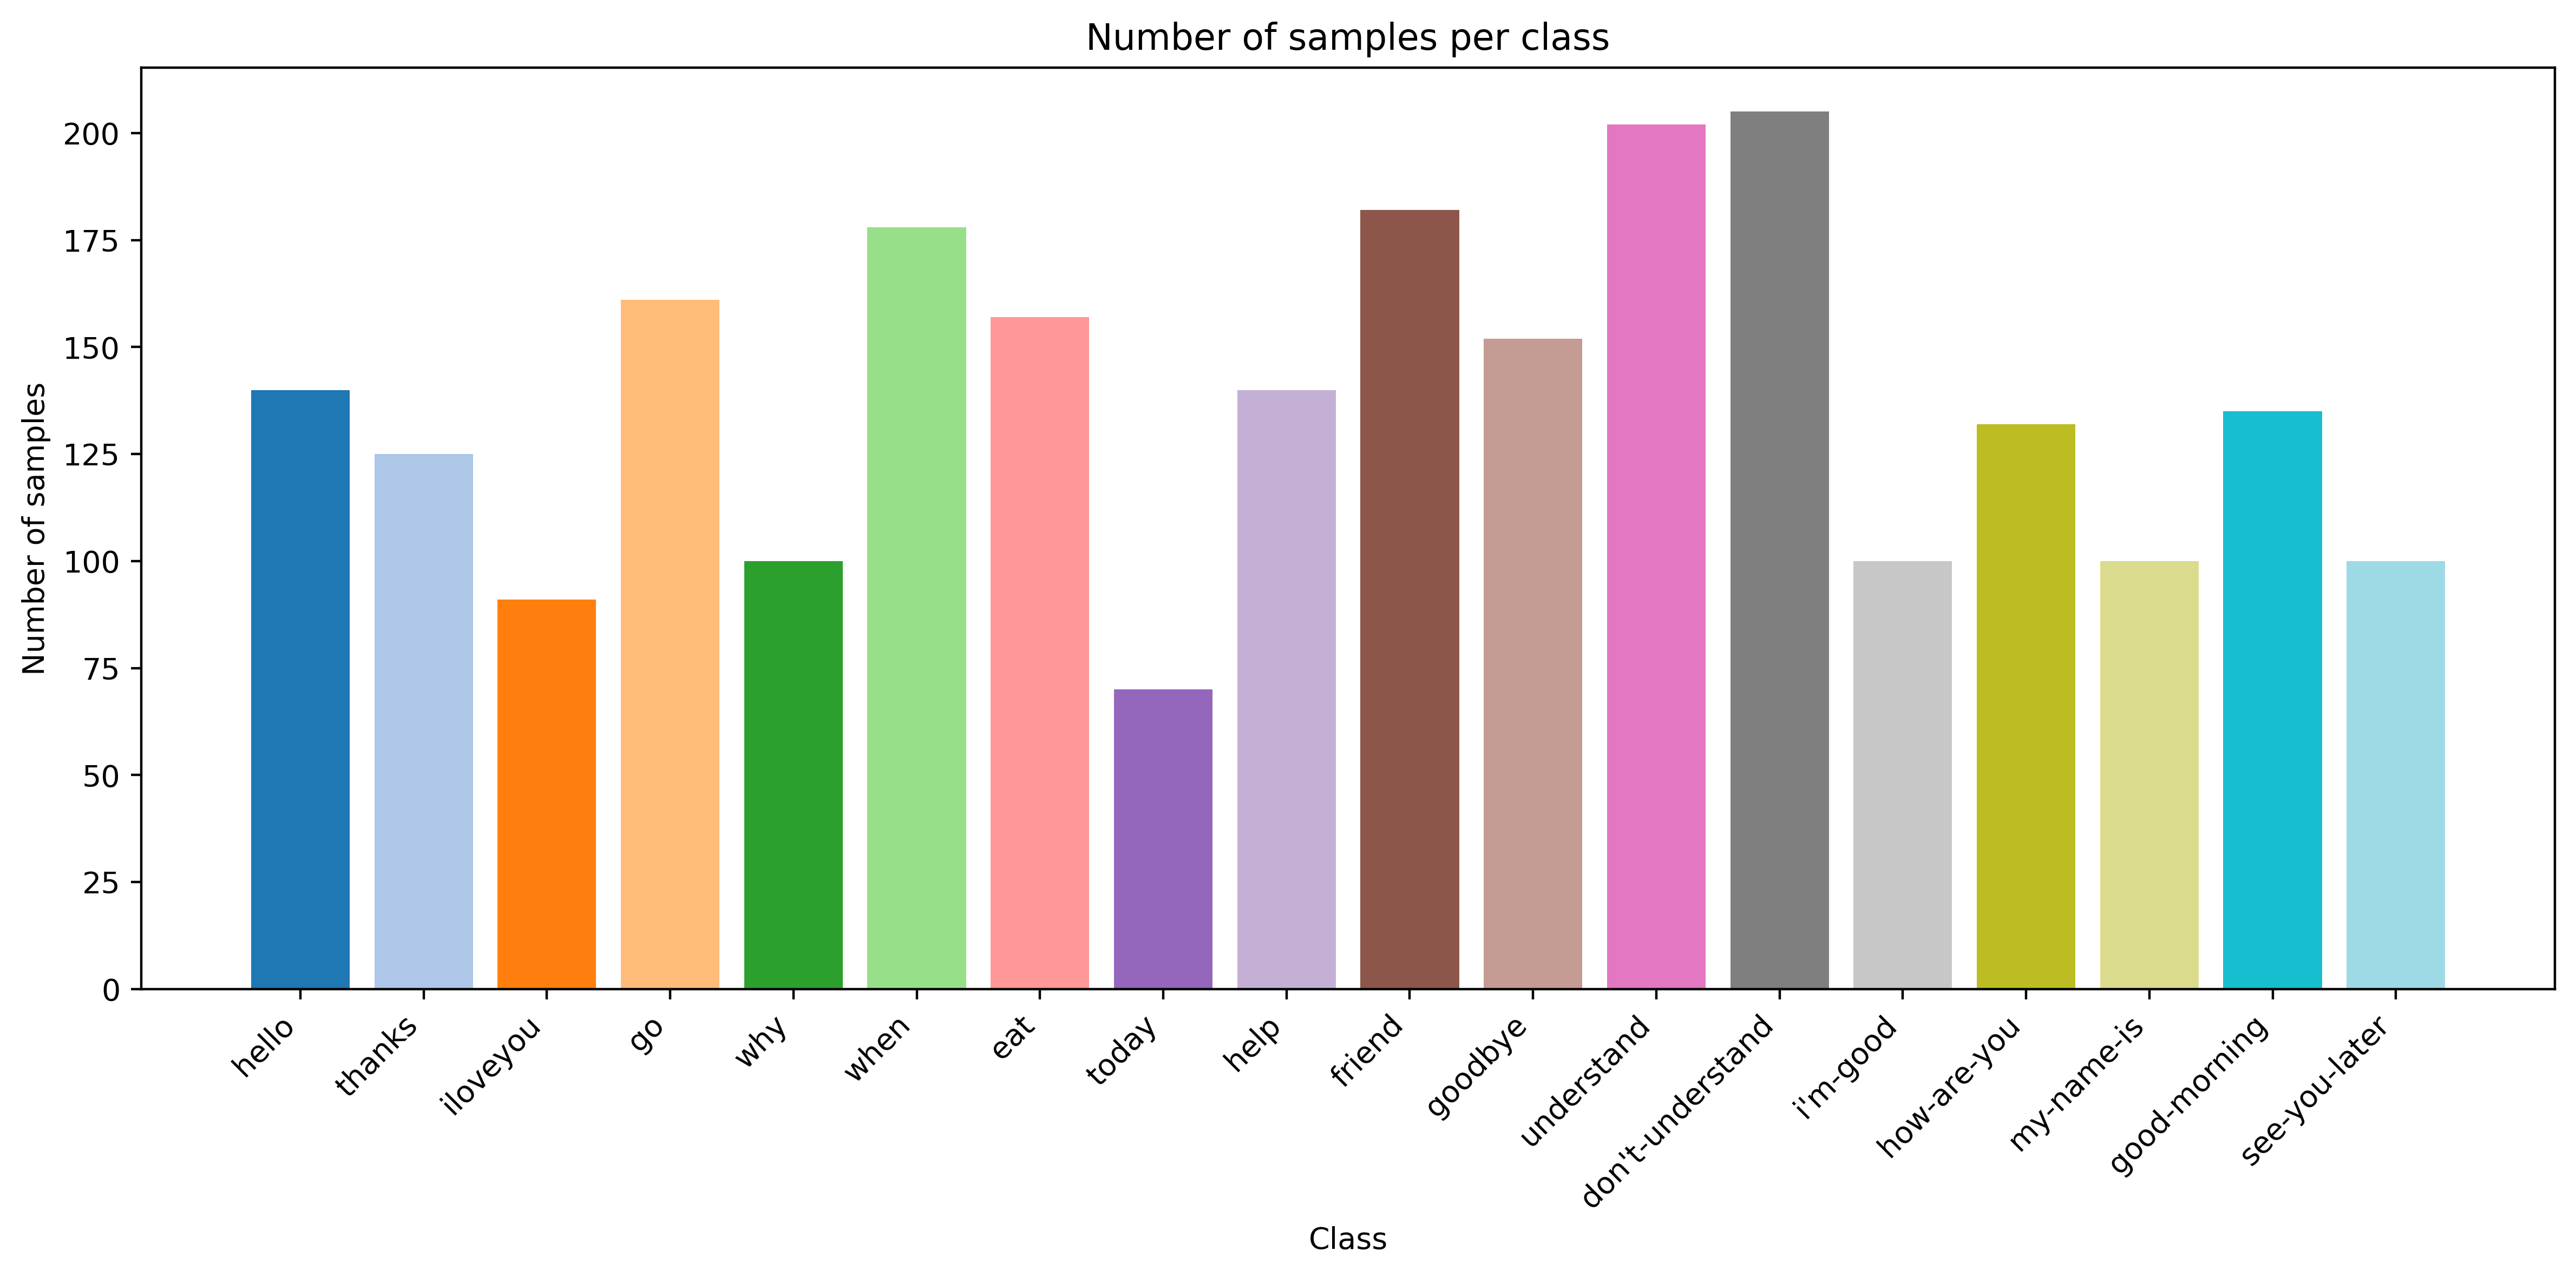

In [35]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

num_to_label = {num: label for label, num in label_map.items()}
labels_named = [num_to_label[label] for label in labels]
label_counts = Counter(labels_named)
classes = list(label_counts.keys())
counts = list(label_counts.values())


# Generate a color palette with as many colors as classes
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))
plt.figure(figsize=(12, 6), dpi=400)

colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

plt.bar(classes, counts, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.tight_layout()

plt.savefig('class_distribution.png', dpi=400)  # Save figure with 400 dpi
plt.show()



## 6. Data Split

In [37]:
from sklearn.model_selection import train_test_split

# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Second split: from train+val → train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=42)

# Summary
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 1666
Validation size: 186
Test size: 618


## 7. Data Augmentation

In [39]:
def augment_mediapipe_frame(flat_keypoints, rotation_deg=5, scale_range=(0.9,1.1), translation_range=0.1, noise_std=0.01):
    # Extract the parts based on your layout
    pose = flat_keypoints[:132].reshape(33, 4)  # includes visibility
    face = flat_keypoints[132:132+1404].reshape(468, 3)
    lh = flat_keypoints[132+1404:132+1404+63].reshape(21, 3)
    rh = flat_keypoints[132+1404+63:].reshape(21, 3)

    def augment_coords(coords):
        # coords shape: (num_keypoints, 3)
        theta = np.radians(np.random.uniform(-rotation_deg, rotation_deg))
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        R = np.array([[cos_t, -sin_t], [sin_t, cos_t]])

        coords[:, :2] = coords[:, :2] @ R.T

        scale = np.random.uniform(*scale_range)
        coords *= scale

        translation = np.random.uniform(-translation_range, translation_range, size=(1,3))
        coords += translation

        noise = np.random.normal(0, noise_std, size=coords.shape)
        coords += noise

        return coords

    # Augment pose spatial coords only (x,y,z), keep visibility unchanged
    pose_spatial = pose[:, :3]
    pose_spatial = augment_coords(pose_spatial)
    pose[:, :3] = pose_spatial

    # Augment other parts
    face = augment_coords(face)
    lh = augment_coords(lh)
    rh = augment_coords(rh)

    # Flatten and re-concatenate everything
    augmented = np.concatenate([
        pose.flatten(),
        face.flatten(),
        lh.flatten(),
        rh.flatten()
    ])

    return augmented
num_augmentations = 10
X_train_augmented = []
y_train_augmented = []

for x, y_label in zip(X_train, y_train):
    X_train_augmented.append(x)
    y_train_augmented.append(y_label)

    for _ in range(num_augmentations):
        augmented_sequence = []
        for frame in x:  # frame shape (1662,)
            frame_aug = augment_mediapipe_frame(frame)
            augmented_sequence.append(frame_aug)
        augmented_sequence = np.array(augmented_sequence)
        X_train_augmented.append(augmented_sequence)
        y_train_augmented.append(y_label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
print(f"original {len(X_train)}")
print(f"Augmented {len(X_train_augmented)}")

original 1666
Augmented 18326


## 8. Model Architecture, Training & Testing

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [41]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [42]:
from tensorflow.keras.layers import Dropout, Masking, Bidirectional, LSTM, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh'), input_shape=(30,1662)))
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(64, return_sequences=False, activation = 'tanh')))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions[:18]), activation='softmax'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tb_callback = TensorBoard(log_dir='logs')

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=360,
    batch_size=64,
    callbacks=[tb_callback, early_stopping]
)

# Model summary
model.summary()

# === Evaluate accuracy on train/val/test ===
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")


Epoch 1/360
287/287 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - categorical_accuracy: 0.9854 - loss: 0.0449 - val_categorical_accuracy: 0.9839 - val_loss: 0.0971
Epoch 2/360
287/287 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - categorical_accuracy: 0.9842 - loss: 0.0472 - val_categorical_accuracy: 0.9785 - val_loss: 0.1359
Epoch 3/360
287/287 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - categorical_accuracy: 0.9883 - loss: 0.0329 - val_categorical_accuracy: 0.9731 - val_loss: 0.0945
Epoch 4/360
287/287 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - categorical_accuracy: 0.9832 - loss: 0.0521 - val_categorical_accuracy: 0.9839 - val_loss: 0.0655
Epoch 5/360
287/287 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - categorical_accuracy: 0.9906 - loss: 0.0317 - val_categorical_accuracy: 0.9624 - val_loss: 0.1092
Epoch 6/360
287/287 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - categorical_accuracy: 0.9849 - loss: 0.0455 - val_categorical_accuracy: 0.9839 - val_loss: 0.1334
Epoch 7/360
287/287 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - catego

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │       884,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,968,024 (15.14 MB)

 Trainable params: 1,322,674 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,645,350 (10.09 MB)

Train Accuracy:      1.0000
Validation Accuracy: 0.9839
Test Accuracy:       0.9854


### Training Vs Validation Loss Plot

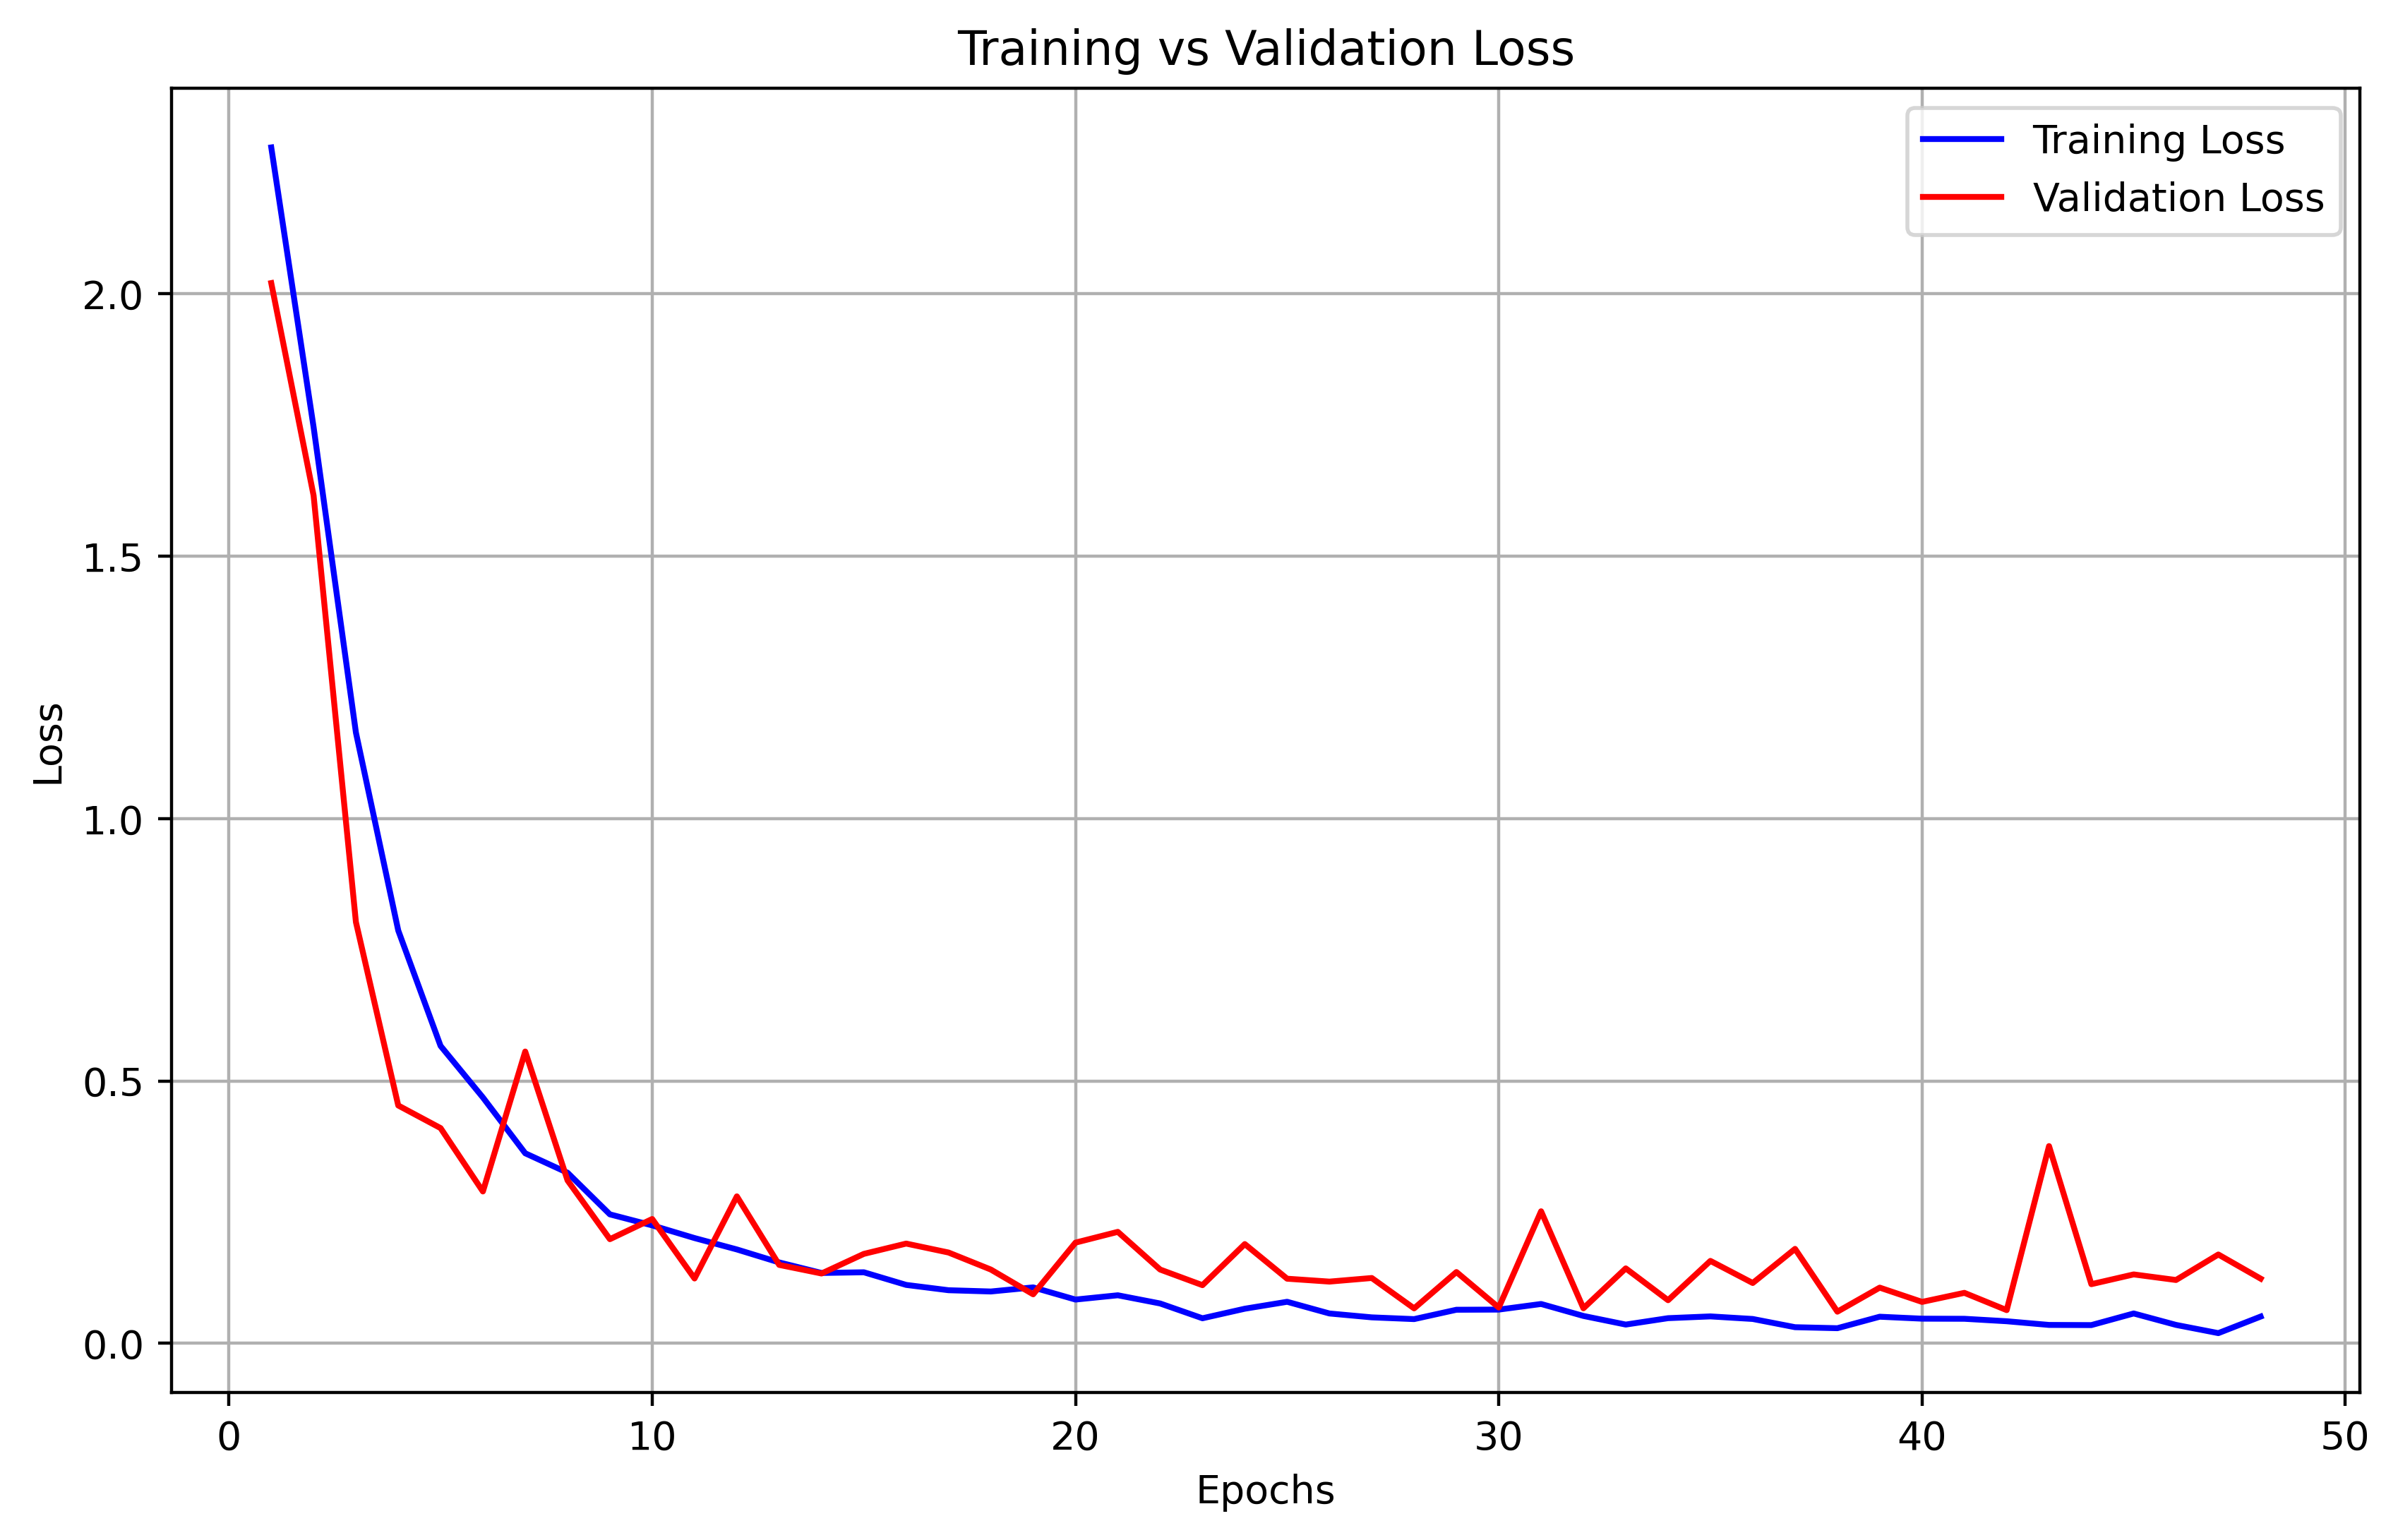

In [51]:
import matplotlib.pyplot as plt

# Extract accuracy values from history
train_acc = history.history['loss']
val_acc = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy per epoch
plt.figure(figsize=(10, 6),dpi=400)
plt.plot(epochs, train_acc, 'b-', label='Training Loss')
plt.plot(epochs, val_acc, 'r-', label='Validation Loss')

# Since test accuracy is a single value (not per epoch), add it as a horizontal line
# plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy ({test_acc:.4f})')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png', dpi=400, bbox_inches='tight')

plt.show()

In [53]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(ytrue, yhat)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

classes_to_plot = [11, 12]

plt.figure(figsize=(10, 5 * len(classes_to_plot)), dpi=400)

for i, class_idx in enumerate(classes_to_plot):
    class_mask = (y_true_labels == class_idx)

    correct_mask = class_mask & (y_pred_labels == y_true_labels)
    incorrect_mask = class_mask & (y_pred_labels != y_true_labels)

    correct_conf_class = confidences[correct_mask]
    incorrect_conf_class = confidences[incorrect_mask]

    plt.subplot(len(classes_to_plot), 1, i + 1)

    x_vals = np.linspace(0, 1, 1000)

    # KDE for correct predictions
    if len(correct_conf_class) > 1:
        kde_correct = gaussian_kde(correct_conf_class)
        y_vals_correct = kde_correct(x_vals)
        plt.plot(x_vals, y_vals_correct, color='g', lw=2, label='Correct Predictions')

    # KDE for incorrect predictions
    if len(incorrect_conf_class) > 1:
        kde_incorrect = gaussian_kde(incorrect_conf_class)
        y_vals_incorrect = kde_incorrect(x_vals)
        plt.plot(x_vals, y_vals_incorrect, color='r', lw=2, label='Incorrect Predictions')

    plt.title(f'{num_to_label[class_idx]} - Confidence Distribution (KDE)')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('confidence_distribution_kde_density_classes_11_12.png', dpi=400, bbox_inches='tight')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


NameError: name 'y_true_labels' is not defined

<Figure size 4000x4000 with 0 Axes>

### Confusion Matrix & Classification Report
# THE RESULTS MIGHT BE DIFFERENT FROM THE ONES REPORTED IN THE DISSERTATION DUE TO THE FURTHER EXPERIMENTS DONE AFTER THE DISSERTATION

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Total inference time: 0.4134 seconds
Average time per sample: 0.000669 seconds
Throughput: 1494.78 samples per second


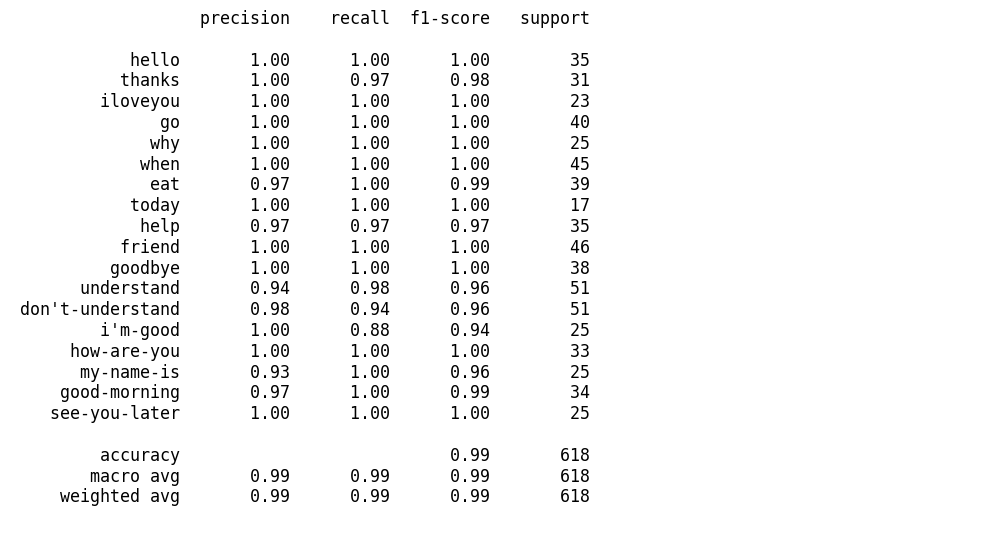

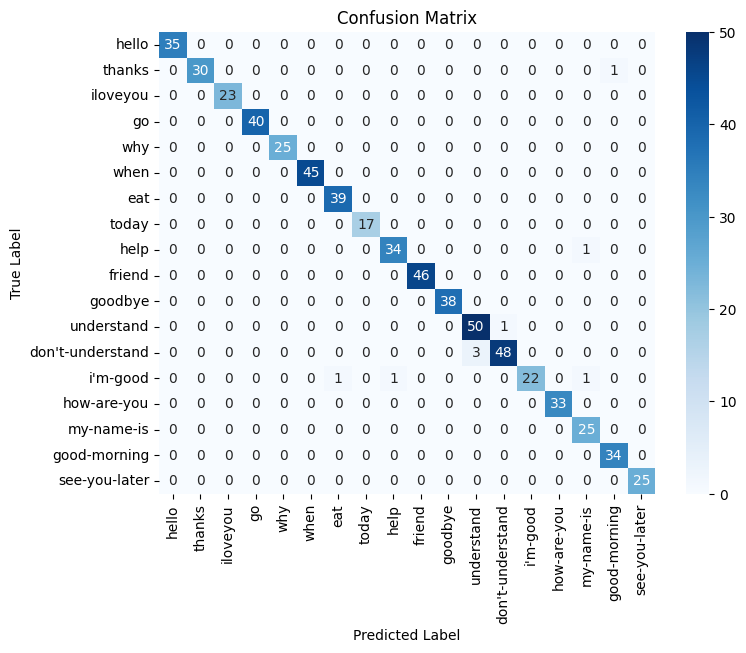

In [77]:
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Start timer for inference ---
start_time = time.time()

# Run predictions (replace with your model's prediction method)
# Example: yhat = model.predict(X_test)
yhat = model.predict(X_test)

end_time = time.time()

# --- Calculate speed metrics ---
total_time = end_time - start_time
num_samples = len(X_test)
time_per_sample = total_time / num_samples
fps = num_samples / total_time  # frames/s or predictions/s

print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per sample: {time_per_sample:.6f} seconds")
print(f"Throughput: {fps:.2f} samples per second")

# --- Convert predictions to discrete labels if needed ---
# If predictions are probabilities or logits
if isinstance(yhat, np.ndarray) and yhat.ndim > 1:
    yhat = np.argmax(yhat, axis=1)

# Convert ytrue to labels if it's one-hot encoded
if isinstance(ytrue, np.ndarray) and ytrue.ndim > 1:
    ytrue = np.argmax(ytrue, axis=1)

# --- Classification report ---
report = classification_report(ytrue, yhat, target_names=classes)

plt.figure(figsize=(10, 6))
plt.text(0.01, 1, report, fontsize=12, fontfamily='monospace',
         verticalalignment='top', wrap=True)
plt.axis('off')
plt.tight_layout()
plt.savefig('classification_report.png', dpi=300)
plt.show()

# --- Confusion matrix ---
cm = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusionmatrix.png', dpi=400, bbox_inches='tight')
plt.show()


### Weighted Average Metrics

In [57]:
def weighted_avg_metric(class_list, metrics_dict, metric_name):
    total_metric = 0
    total_support = 0
    for cls in class_list:
        metric = metrics_dict[cls][metric_name.lower()]  
        support = metrics_dict[cls]['support']
        total_metric += metric * support
        total_support += support
    return total_metric / total_support if total_support > 0 else 0

# dynamic and static glosses
dynamic_glosses = ['good-morning', "i'm-good", 'help', 'see-you-later', "don't-understand", 'understand', 'my-name-is', 'how-are-you']

# Static glosses are all others not in dynamic_glosses
static_glosses = [cls for cls in class_metrics.keys() if cls not in dynamic_glosses]

# Calculate weighted precision and recall for dynamic glosses
avg_precision_dynamic = weighted_avg_metric(dynamic_glosses, class_metrics, 'precision')
avg_recall_dynamic = weighted_avg_metric(dynamic_glosses, class_metrics, 'recall')

# Calculate weighted precision and recall for static glosses
avg_precision_static = weighted_avg_metric(static_glosses, class_metrics, 'precision')
avg_recall_static = weighted_avg_metric(static_glosses, class_metrics, 'recall')

print(f"Weighted average Precision for dynamic glosses: {avg_precision_dynamic:.4f}")
print(f"Weighted average Recall for dynamic glosses: {avg_recall_dynamic:.4f}")
print(f"Weighted average Precision for static glosses: {avg_precision_static:.4f}")
print(f"Weighted average Recall for static glosses: {avg_recall_static:.4f}")
import numpy as np

# Convert one-hot to label indices if needed
if isinstance(y_train[0], np.ndarray) and y_train[0].ndim > 0:
    y_train_labels = np.argmax(y_train, axis=1)
else:
    y_train_labels = y_train

# Map numeric labels to gloss names
train_labels_named = [num_to_label[label] for label in y_train_labels]

# Count dynamic and static samples
dynamic_count = sum(1 for gloss in train_labels_named if gloss in dynamic_glosses)
static_count = len(train_labels_named) - dynamic_count

print(f"Number of dynamic gloss samples in training set: {dynamic_count}")
print(f"Number of static gloss samples in training set: {static_count}")


NameError: name 'class_metrics' is not defined

## 9. Uniform Sampling Evaluation

In [60]:
import cv2
import os
import time
import numpy as np
import mediapipe as mp

# === Actions (glosses) ===
actions = np.array([
    'hello', 'thanks', 'iloveyou', 'go', 'why', 'when', 'eat', 'today', 'help',
    'friend', 'goodbye', 'understand', "don't-understand",
    "i'm-good", 'how-are-you', 'my-name-is', 'good-morning', 'see-you-later'
])

# === Base directory for dataset ===
base_dir = '/Users/badershalata/Documents/MP_Data/testing'
os.makedirs(base_dir, exist_ok=True)

# === MediaPipe setup ===
mp_holistic = mp.solutions.holistic


# === Webcam capture ===
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(static_image_mode=False, model_complexity=1) as holistic:
    for gloss in actions:
        gloss_dir = os.path.join(base_dir, gloss)  # Keep lowercase as provided
        os.makedirs(gloss_dir, exist_ok=True)

        print(f"\n📂 Starting recordings for gloss: {gloss}")

        for vid_num in range(1, 21):  # 20 recordings
            frame_count = 0
            max_frames = np.random.randint(30, 100)  # random length

            # Create subfolder for this video
            vid_folder = os.path.join(gloss_dir, f"vid{vid_num:02d}")
            if os.path.exists(vid_folder):
                print(f"⚠️ Skipping {vid_folder} (already exists)")
                continue
            os.makedirs(vid_folder)

            # Countdown before recording
            for sec in range(3, 0, -1):
                ret, frame = cap.read()
                if not ret:
                    break
                text = f"Gloss: {gloss} | Start in {sec}..."
                cv2.putText(frame, text, (50, 200),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
                cv2.imshow('Recording...', frame)
                cv2.waitKey(300)

            print(f"🎥 Recording #{vid_num} for {gloss} ({max_frames} frames)")

            while frame_count < max_frames:
                ret, frame = cap.read()
                if not ret:
                    break

                # Process with MediaPipe
                image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image_rgb.flags.writeable = False
                results = holistic.process(image_rgb)

                # Extract keypoints
                keypoints = extract_keypoints(results)

                # Save keypoints for this frame
                frame_filename = os.path.join(
                    vid_folder, f"frame{frame_count:04d}.npy"
                )
                np.save(frame_filename, keypoints)

                # Show frame with info
                label_text = f"{gloss} | Vid {vid_num} | Frame {frame_count+1}/{max_frames}"
                cv2.putText(frame, label_text, (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.imshow('Recording...', frame)

                frame_count += 1
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

print("\n✅ All recordings done.")
cap.release()
cv2.destroyAllWindows()


2025-08-14 17:18:29.459 python[4686:64620] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1755181110.850418   64620 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1755181110.916520  101002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755181110.927319  101002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755181110.929258  101002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755181110.929773  101000 inference_fee


📂 Starting recordings for gloss: hello
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid01 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid02 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid03 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid04 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid05 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid06 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid07 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid08 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid09 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid10 (already exists)
⚠️ Skipping /Users/badershalata/Documents/MP_Data/testing/hello/vid11 (already exists)
⚠️ 

In [62]:
import numpy as np
import os
from tensorflow.keras.models import load_model

base_dir = '/Users/badershalata/Documents/MP_Data/testing'

def sample_to_30_frames(sequence):
    indices = np.linspace(0, len(sequence) - 1, 30).astype(int)
    return sequence[indices]

def load_keypoints_from_folder(vid_folder_path):
    files = sorted([f for f in os.listdir(vid_folder_path) if f.endswith('.npy')])
    all_keypoints = []
    for file in files:
        keypoints = np.load(os.path.join(vid_folder_path, file))
        all_keypoints.append(keypoints)
    return np.array(all_keypoints)

true_labels = []
predicted_labels = []

# For accuracy per class:
class_correct = {label: 0 for label in actions}
class_total = {label: 0 for label in actions}

# For average frame length per gloss:
class_frame_lengths = {label: [] for label in actions}

for gloss in actions:
    gloss_dir = os.path.join(base_dir, gloss)
    if not os.path.exists(gloss_dir):
        print(f"⚠️ Directory {gloss_dir} does not exist, skipping.")
        continue

    vid_folders = [f for f in os.listdir(gloss_dir) if os.path.isdir(os.path.join(gloss_dir, f))]
    vid_folders = sorted(vid_folders)

    for vid in vid_folders:
        vid_folder_path = os.path.join(gloss_dir, vid)
        keypoints_seq = load_keypoints_from_folder(vid_folder_path)
        
        # Track original video length before sampling/padding
        original_len = len(keypoints_seq)
        class_frame_lengths[gloss].append(original_len)

        if original_len >= 30:
            sampled_keypoints = sample_to_30_frames(keypoints_seq)
        else:
            pad_len = 30 - original_len
            pad = np.zeros((pad_len, keypoints_seq.shape[1]))
            sampled_keypoints = np.vstack((keypoints_seq, pad))

        input_data = np.expand_dims(sampled_keypoints, axis=0)

        prediction = model.predict(input_data)
        predicted_class_index = np.argmax(prediction)
        predicted_label = actions[predicted_class_index]

        true_labels.append(gloss)
        predicted_labels.append(predicted_label)

        class_total[gloss] += 1
        if predicted_label == gloss:
            class_correct[gloss] += 1

        print(f"Video: {gloss}/{vid} | Predicted: {predicted_label} | Frames: {original_len}")

# Overall accuracy
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
accuracy = np.mean(true_labels == predicted_labels)
print(f"\n✅ Overall accuracy on dataset: {accuracy * 100:.2f}%\n")

# Accuracy per class and average frames
print("📊 Accuracy and average video length per class:")
for gloss in actions:
    if class_total[gloss] > 0:
        acc = class_correct[gloss] / class_total[gloss]
        avg_len = np.mean(class_frame_lengths[gloss])
        print(f"{gloss:<15}: Accuracy: {acc * 100:.2f}% ({class_correct[gloss]}/{class_total[gloss]}) | Avg frames: {avg_len:.1f}")
    else:
        print(f"{gloss:<15}: No samples")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Video: hello/vid01 | Predicted: hello | Frames: 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Video: hello/vid02 | Predicted: hello | Frames: 51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Video: hello/vid03 | Predicted: hello | Frames: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Video: hello/vid04 | Predicted: hello | Frames: 85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Video: hello/vid05 | Predicted: hello | Frames: 56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Video: hello/vid06 | Predicted: hello | Frames: 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Video: hello/vid07 | Predicted: hello | Frames: 75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Video: hello/vid08 | Predicted: hello | Frames: 75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Video: hello/vid09 | Predicted: hello | Frames: 97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Video: hello/vid10 | Predicted: hello | Frames: 76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Video: hello/vid11 | Predicted: hello | Frames: 36
1/1 ━━━━━━━━━━━━━━━━━

## 10. Test in REAL TIME

In [ ]:
import cv2
import numpy as np
import mediapipe as mp

sequence = []
sentence = []
threshold = 0.9
res = np.array([])  # Initialize to avoid NameError

# Variables for consecutive frame check
consecutive_frames_required = 5
consistent_count = 0
last_action = None

cap = cv2.VideoCapture(0)

with mp.solutions.holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Extract keypoints
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep last 30 frames

        # Predict when we have 30 frames
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            confidence = res[np.argmax(res)]
            action = actions[np.argmax(res)]
            print(f"Predicted: {action} | Confidence: {confidence:.2f}")

            if confidence > threshold:
                if action == last_action:
                    consistent_count += 1
                else:
                    consistent_count = 1
                    last_action = action

                if consistent_count >= consecutive_frames_required:
                    if len(sentence) == 0 or action != sentence[-1]:
                        sentence.append(action)
            else:
                consistent_count = 0
                last_action = None

        # Keep last 5 predictions in sentence
        sentence = sentence[-5:]

        # Visualize sentence on the image
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Display the frame
        cv2.imshow('OpenCV Feed', image)

        # Exit condition
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


### Save Model

In [71]:
model.save("signlanguagemodel.keras")